In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from fuzzywuzzy import fuzz

In [2]:
autism_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/austim_tweets_with_sentiment-all.csv')
control_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_tweets_with_sentiment-all.csv')


print(autism_tweets_df.head())
print(control_tweets_df.head())
print(autism_tweets_df.isnull().sum())
print(control_tweets_df.isnull().sum())

                                             User_ID  Friends count  \
0  4d40ced1122d03ff51565e460723aa88cf10da83a47872...            152   
1  60f8e994a389fc65557cdf594582e5764fab50766cd13b...           1756   
2  975f72be21fc87c6701385533e6e25c789a84e0f4074b8...           1278   
3  a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...            771   
4  60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...           3692   

   Followers count                 Tweet date             Tweet id  \
0              361  2022-12-31 23:01:30+00:00  1609323893193318401   
1             2868  2022-12-31 21:42:00+00:00  1609303887030243330   
2              280  2022-12-31 20:20:12+00:00  1609283300857909250   
3              752  2022-12-31 20:15:30+00:00  1609282116965257219   
4             1733  2022-12-31 20:13:32+00:00  1609281620657467398   

                                          Tweet text  \
0  hi , 'm xironium , actuallyautistic gamer/stre...   
1  happynewyear friend ! 🥂 grateful wond

In [3]:
control_tweets_df.describe

<bound method NDFrame.describe of                                                   User_ID  Friends count  \
0       0aa837fd4fa1a7b5da1408f8288d3e20ad53fa95ffcbeb...            648   
1       824a494eb5be73f7118ad421e80b829c4646cad458d233...            626   
2       749acd73361c361cffb38c0767eb27a907a0d3bd9ec03d...           1816   
3       2f8b0dfec60e7b93bd8a9d9573a365c19f5c89da7c04ec...            343   
4       e31b4092e6a8e8f8d574b25f58c994a4daedccbdf5beb8...           3024   
...                                                   ...            ...   
353116  9d9de97e2728bfb678b42106d562ff6a717741e09ea3e8...            428   
353117  0e085ee4bd8318ca32f3a76c7ead69b02327851abfcd45...            875   
353118  b112290ca597173d3f1c81976f83917eb2ebb5bd1020cb...            578   
353119  2db4fcb844164e37a530101430a5fd4f7285ddc2269f85...            279   
353120  399e8c00f5ef00dcd78be74e7e5958abc8c41d5585c259...            489   

        Followers count                 Tweet date   

In [4]:
autism_tweets_df.describe

<bound method NDFrame.describe of                                                   User_ID  Friends count  \
0       4d40ced1122d03ff51565e460723aa88cf10da83a47872...            152   
1       60f8e994a389fc65557cdf594582e5764fab50766cd13b...           1756   
2       975f72be21fc87c6701385533e6e25c789a84e0f4074b8...           1278   
3       a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...            771   
4       60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...           3692   
...                                                   ...            ...   
974696  faa292fb76fdff7082d8965b9f457901c7c062e7891d6d...             66   
974697  dfaa361625a3b4a261812bd5dd76434c224a8c5a51237c...             14   
974698  8d8726806b7334187326994cd77d1ec25c7566d9f18965...            263   
974699  8d8726806b7334187326994cd77d1ec25c7566d9f18965...            263   
974700  c60e8557aec619dc60889306a57494497e062607e18bd7...            109   

        Followers count                 Tweet date   

In [5]:
# Function to find similar tweets and drop them
def drop_similar_tweets(df):
    to_drop = []
    grouped = df.groupby(['User_ID', 'Tweet id'])

    for name, group in grouped:
        if len(group) > 1:
            for i in range(len(group)):
                for j in range(i + 1, len(group)):
                    if fuzz.ratio(group.iloc[i]['Tweet text'], group.iloc[j]['Tweet text']) > 80:
                        to_drop.append(group.index[j])

    return df.drop(to_drop)

In [6]:
# Drop similar tweets in both datasets
autism_tweets_df = drop_similar_tweets(autism_tweets_df)
control_tweets_df = drop_similar_tweets(control_tweets_df)

# Print the cleaned dataframes
print(autism_tweets_df.head())
print(control_tweets_df.head())

# Check for null values
print(autism_tweets_df.isnull().sum())
print(control_tweets_df.isnull().sum())

                                             User_ID  Friends count  \
0  4d40ced1122d03ff51565e460723aa88cf10da83a47872...            152   
1  60f8e994a389fc65557cdf594582e5764fab50766cd13b...           1756   
2  975f72be21fc87c6701385533e6e25c789a84e0f4074b8...           1278   
3  a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...            771   
4  60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...           3692   

   Followers count                 Tweet date             Tweet id  \
0              361  2022-12-31 23:01:30+00:00  1609323893193318401   
1             2868  2022-12-31 21:42:00+00:00  1609303887030243330   
2              280  2022-12-31 20:20:12+00:00  1609283300857909250   
3              752  2022-12-31 20:15:30+00:00  1609282116965257219   
4             1733  2022-12-31 20:13:32+00:00  1609281620657467398   

                                          Tweet text  \
0  hi , 'm xironium , actuallyautistic gamer/stre...   
1  happynewyear friend ! 🥂 grateful wond

In [7]:
print("New total number of rows:", autism_tweets_df.shape[0])
print("New total number of rows:", control_tweets_df.shape[0])

New total number of rows: 974686
New total number of rows: 352131


### Hashtags detailed info

In [8]:
# Replace NaN values in the 'Hashtags' column with empty lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].fillna('[]')
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].fillna('[]')

# Convert the 'Hashtags' column strings to lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].apply(ast.literal_eval)
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].apply(ast.literal_eval)

# Flatten the lists of hashtags and count the frequencies for each dataset
control_hashtags = [hashtag for sublist in control_tweets_df['Hashtags'] for hashtag in sublist]
autism_hashtags = [hashtag for sublist in autism_tweets_df['Hashtags'] for hashtag in sublist]

control_hashtag_freq = Counter(control_hashtags)
autism_hashtag_freq = Counter(autism_hashtags)

# Convert Counter objects to DataFrames
control_hashtag_df = pd.DataFrame(control_hashtag_freq.items(), columns=[ 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)
autism_hashtag_df = pd.DataFrame(autism_hashtag_freq.items(), columns=[ 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)

In [9]:
# Print the DataFrames
print("Control Hashtag Frequencies:")
print(control_hashtag_df)

print("\nAutism Hashtag Frequencies:")
print(autism_hashtag_df)

Control Hashtag Frequencies:
                     Hashtag  Count
515             WrestleMania   1718
7244    MyTwitterAnniversary   1718
443             iHeartAwards   1655
8083              SoundCloud   1543
488               NowPlaying   1459
...                      ...    ...
80068           writingbooks      1
80067                 STEMed      1
80065                 pbfest      1
80062                pbparty      1
182663         MyStupidMouth      1

[182664 rows x 2 columns]

Autism Hashtag Frequencies:
                        Hashtag   Count
0              ActuallyAutistic  157943
23                       autism   65707
31                       Autism   35424
9              actuallyautistic   34624
80                     autistic   28488
...                         ...     ...
165161              megaconlive       1
165162              MegaConLive       1
165163        megaconmanchester       1
165164  VioletEvergardencosplay       1
355163               USTsped740       1

[3

In [10]:
# Get the top 50 hashtags
top_50_control_hashtags = control_hashtag_freq.most_common(50)
top_50_autism_hashtags = autism_hashtag_freq.most_common(50)


In [11]:
top_50_control_hashtags

[('WrestleMania', 1718),
 ('MyTwitterAnniversary', 1718),
 ('iHeartAwards', 1655),
 ('SoundCloud', 1543),
 ('NowPlaying', 1459),
 ('TikTok', 1317),
 ('NintendoSwitch', 1233),
 ('np', 1128),
 ('MTVHottest', 1075),
 ('Twitterversary', 1059),
 ('MTVStars', 1053),
 ('LoveIsland', 975),
 ('BTSBBMAs', 926),
 ('SuperBowl', 892),
 ('MarchMadness', 862),
 ('BestFanArmy', 861),
 ('BTS', 833),
 ('loveisland', 772),
 ('MostRequestedLive', 768),
 ('music', 768),
 ('TeenChoice', 751),
 ('PS4live', 743),
 ('AMAs', 678),
 ('WWE', 671),
 ('shopmycloset', 654),
 ('NewProfilePic', 583),
 ('Wrestlemania', 563),
 ('NFL', 561),
 ('KCA', 558),
 ('EMABiggestFansJustinBieber', 550),
 ('NP', 540),
 ('nowplaying', 526),
 ('twitch', 525),
 ('PS4share', 507),
 ('art', 497),
 ('Oscars', 494),
 ('tvtime', 492),
 ('AEWDynamite', 488),
 ('podcast', 486),
 ('COVID19', 484),
 ('SpotifyWrapped', 461),
 ('TheBachelor', 456),
 ('PS5Share', 450),
 ('CallMeCam', 433),
 ('MTVSTARS', 429),
 ('love', 422),
 ('FlyEaglesFly', 422

In [12]:
top_50_autism_hashtags

[('ActuallyAutistic', 157943),
 ('autism', 65707),
 ('Autism', 35424),
 ('actuallyautistic', 34624),
 ('autistic', 28488),
 ('AskingAutistics', 15382),
 ('AutismAwareness', 12791),
 ('ADHD', 11851),
 ('AutismAcceptance', 10112),
 ('autismawareness', 8694),
 ('NintendoSwitch', 8590),
 ('Autistic', 8545),
 ('mentalhealth', 8429),
 ('Neurodiversity', 8218),
 ('ASD', 6624),
 ('neurodiversity', 6316),
 ('art', 6255),
 ('autismacceptance', 6190),
 ('Neurodivergent', 6038),
 ('WritingCommunity', 5435),
 ('AutismAcceptanceMonth', 4825),
 ('COVID19', 4491),
 ('aspergers', 4283),
 ('asd', 4205),
 ('AllAutistics', 3983),
 ('adhd', 3847),
 ('neurodivergent', 3669),
 ('DisabilityTwitter', 3420),
 ('amwriting', 3328),
 ('ACNH', 3320),
 ('AnimalCrossing', 3201),
 ('anxiety', 3200),
 ('inclusion', 2983),
 ('disability', 2953),
 ('SEND', 2917),
 ('TikTok', 2834),
 ('MentalHealth', 2766),
 ('NEISvoid', 2638),
 ('depression', 2591),
 ('AuDHD', 2532),
 ('education', 2503),
 ('MentalHealthMatters', 2470),


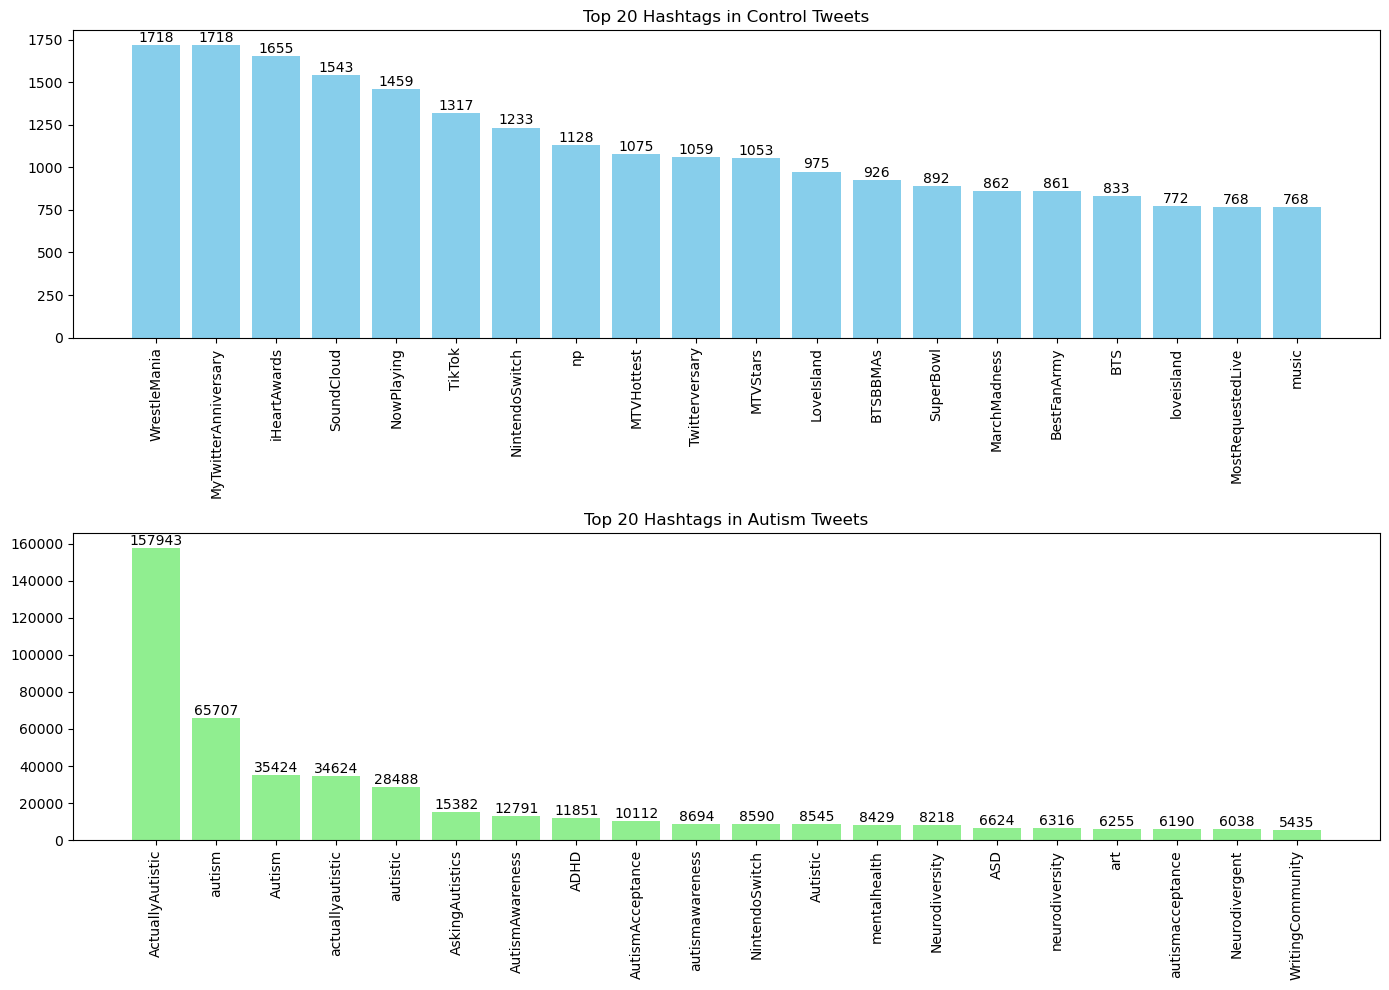

In [13]:
# Get the top 20 hashtags
top_20_control_hashtags = control_hashtag_freq.most_common(20)
top_20_autism_hashtags = autism_hashtag_freq.most_common(20)

# Plot the top 20 hashtags comparison
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

control_hashtags_df = pd.DataFrame(
    top_20_control_hashtags, columns=['Hashtag', 'Count'])
autism_hashtags_df = pd.DataFrame(
    top_20_autism_hashtags, columns=['Hashtag', 'Count'])

# Plot for Control Tweets
axs[0].bar(control_hashtags_df.index,
           control_hashtags_df['Count'], color='skyblue')
axs[0].set_title('Top 20 Hashtags in Control Tweets')
axs[0].set_xticks(control_hashtags_df.index)
axs[0].set_xticklabels(control_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(control_hashtags_df['Count']):
    axs[0].text(i, v + 0.5, str(v), ha='center', va='bottom')

# Plot for Autism Tweets
axs[1].bar(autism_hashtags_df.index,
           autism_hashtags_df['Count'], color='lightgreen')
axs[1].set_title('Top 20 Hashtags in Autism Tweets')
axs[1].set_xticks(autism_hashtags_df.index)
axs[1].set_xticklabels(autism_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(autism_hashtags_df['Count']):
    axs[1].text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### topic modelling on "Hashtags": add another column which store 1 for all strings are about autism; 0 for nothing about autism; 2 for both

In [14]:
# Define the list of autism-related hashtags
autism_related_hashtags = [
    'ActuallyAutistic', 'AskingAutistics', 'actuallyautistic', 'ADHD', 'autism', 'Neurodivergent', 'AuDHD', 'autistic', 'Autism', 
    'MentalHealth', 'AutisticTwitter','adhd', 'asd', 'aspie', 'MentalIllness', 'MentalHealthMatters','AutismAwareness', 'AutismAcceptance', 
    'autismawareness', 'Autistic','ASD', 'autismacceptance', 'Neurodivergent', 'aspergers', 'AllAutistics', 'neurodivergent',
    'DisabilityTwitter',  'depression','Aspergers', 'Disability',  'MentalHealthAwareness', 'autchat',
    'PTSD', 'neurodiversesquad', 'AutismAwarenessMonth', 'adhdtwitter', 'CPTSD', 'StopTheShock', 'Activate4Autism', 'awesomism'
]

# Function to determine the value of 'hashtag_top'
def determine_hashtag_top(hashtags):
    if not hashtags:
        return 0
    autism_tags = [tag for tag in hashtags if tag in autism_related_hashtags]
    if len(autism_tags) == len(hashtags):
        return 1
    elif len(autism_tags) == 0:
        return 0
    else:
        return 2


# Apply the function to create the 'hashtag_top' column
control_tweets_df['hashtag_top'] = control_tweets_df['Hashtags'].apply(
    determine_hashtag_top)
autism_tweets_df['hashtag_top'] = autism_tweets_df['Hashtags'].apply(
    determine_hashtag_top)

# Display the first few rows of the updated DataFrames
control_tweets_df.head(), autism_tweets_df.head()

(                                             User_ID  Friends count  \
 0  0aa837fd4fa1a7b5da1408f8288d3e20ad53fa95ffcbeb...            648   
 1  824a494eb5be73f7118ad421e80b829c4646cad458d233...            626   
 2  749acd73361c361cffb38c0767eb27a907a0d3bd9ec03d...           1816   
 3  2f8b0dfec60e7b93bd8a9d9573a365c19f5c89da7c04ec...            343   
 4  e31b4092e6a8e8f8d574b25f58c994a4daedccbdf5beb8...           3024   
 
    Followers count                 Tweet date             Tweet id  \
 0              299  2015-07-01 23:59:56+00:00   616395848411410432   
 1              617  2014-01-28 23:59:56+00:00   428316542674030592   
 2             5103  2020-07-03 23:59:49+00:00  1279203223539195904   
 3              162  2015-06-11 23:59:50+00:00   609148064817938432   
 4             5998  2018-03-20 23:59:36+00:00   976246914164428801   
 
                                           Tweet text        Hashtags  \
 0                         want 2 goal lady . lioness     [Liones

# save the final files for network, user-interaction network

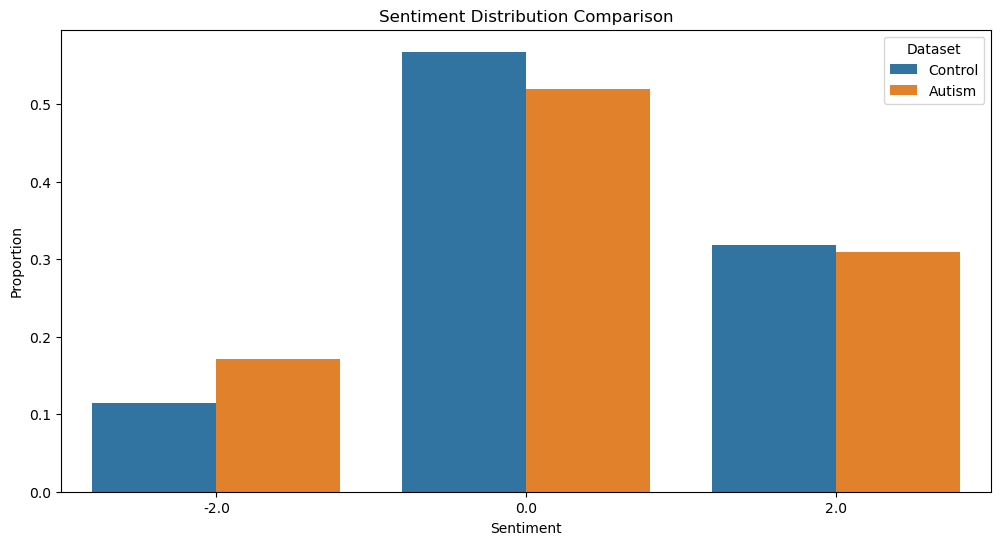

Chi-Square Test Results:
Chi2 Statistic: 13.981080599791575
P-value: 0.007355684080197771
The sentiment distributions between the two groups are significantly different.


In [15]:
# Extract sentiment distributions
control_sentiment_dist = control_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)
autism_sentiment_dist = autism_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)

# Combine sentiment distributions into a DataFrame for visualization
sentiment_dist_df = pd.DataFrame({
    'Sentiment': control_sentiment_dist.index,
    'Control': control_sentiment_dist.values,
    'Autism': autism_sentiment_dist.reindex(control_sentiment_dist.index).fillna(0).values
}).melt(id_vars='Sentiment', var_name='Dataset', value_name='Proportion')

# Visualize sentiment distributions
plt.figure(figsize=(12, 6))
sns.barplot(x='Sentiment', y='Proportion',
            hue='Dataset', data=sentiment_dist_df)
plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.show()

# Statistical test: Chi-Square test of independence
contingency_table = pd.crosstab(
    control_tweets_df['Tweet Text Sentiment'], autism_tweets_df['Tweet Text Sentiment'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Test Results:\nChi2 Statistic: {chi2}\nP-value: {p}")

# Interpretation based on p-value
if p < 0.05:
    print("The sentiment distributions between the two groups are significantly different.")
else:
    print("There is no significant difference in the sentiment distributions between the two groups.")

In [16]:
# Ensure counts are integers and handle NaNs
control_tweets_df['Reply count'] = control_tweets_df['Reply count'].fillna(0).astype(int)
control_tweets_df['Retweet count'] = control_tweets_df['Retweet count'].fillna(0).astype(int)
control_tweets_df['Like count'] = control_tweets_df['Like count'].fillna(0).astype(int)

autism_tweets_df['Reply count'] = autism_tweets_df['Reply count'].fillna(0).astype(int)
autism_tweets_df['Retweet count'] = autism_tweets_df['Retweet count'].fillna(0).astype(int)
autism_tweets_df['Like count'] = autism_tweets_df['Like count'].fillna(0).astype(int)

In [17]:
control_tweets_df.describe

<bound method NDFrame.describe of                                                   User_ID  Friends count  \
0       0aa837fd4fa1a7b5da1408f8288d3e20ad53fa95ffcbeb...            648   
1       824a494eb5be73f7118ad421e80b829c4646cad458d233...            626   
2       749acd73361c361cffb38c0767eb27a907a0d3bd9ec03d...           1816   
3       2f8b0dfec60e7b93bd8a9d9573a365c19f5c89da7c04ec...            343   
4       e31b4092e6a8e8f8d574b25f58c994a4daedccbdf5beb8...           3024   
...                                                   ...            ...   
353116  9d9de97e2728bfb678b42106d562ff6a717741e09ea3e8...            428   
353117  0e085ee4bd8318ca32f3a76c7ead69b02327851abfcd45...            875   
353118  b112290ca597173d3f1c81976f83917eb2ebb5bd1020cb...            578   
353119  2db4fcb844164e37a530101430a5fd4f7285ddc2269f85...            279   
353120  399e8c00f5ef00dcd78be74e7e5958abc8c41d5585c259...            489   

        Followers count                 Tweet date   

In [18]:
# Select relevant columns
columns = ['User_ID', 'Tweet id', 'Tweet date', 'Retweet count', 'Tweet text', 
           'Reply count', 'Tweet Text Sentiment', 'hashtag_top', 'Like count']

control_user_df = control_tweets_df[columns]
autism_user_df = autism_tweets_df[columns]

# Filter rows to keep only those with 'Tweet id' appearing multiple times
control_user_df = control_user_df[control_user_df['Retweet count'] > 0]
autism_user_df = autism_user_df[autism_user_df['Retweet count'] > 0]

In [19]:
print("New total number of rows:", control_user_df.shape[0])
print("New total number of rows:", autism_user_df.shape[0])

New total number of rows: 70790
New total number of rows: 333205


In [20]:
# Save the filtered data to new CSV files
filtered_control_user_file = '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_user.csv'
filtered_autism_user_file = '/Users/xuenichen/Desktop/BEF_Chen/dataset/autism_user.csv'

control_user_df.to_csv(filtered_control_user_file, index=False)
autism_user_df.to_csv(filtered_autism_user_file, index=False)

print(f"Filtered control user data saved to {filtered_control_user_file}")
print(f"Filtered autism user data saved to {filtered_autism_user_file}")

Filtered control user data saved to /Users/xuenichen/Desktop/BEF_Chen/dataset/control_user.csv
Filtered autism user data saved to /Users/xuenichen/Desktop/BEF_Chen/dataset/autism_user.csv
